In [883]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import subprocess
import os
import urllib.request
import unidecode
#%matplotlib inline

def read_metro_name():
    metroline_names = []
    filenames = []
    with open('Twitter_accounts.txt', 'r') as f:
        files = f.readlines()
        for fi in files:
                onefile = fi.rstrip('\n')
                metroline_names.append(onefile)
                filenames.append('user_timeline_'+onefile+'.jsonl')
    return metroline_names, filenames

def clean_text(text):
    text = text.lower()
    text = re.sub(r"-", " ", text)
    text = re.sub(r"\sd\'", "de ", text)
    text = re.sub(r"\sl\'", "le ", text)
    text = re.sub(r"\bl\'", "le ", text)

    text = re.sub(r"\sle\s", " ", text)
    text = re.sub(r"\sla\s", " ", text)
    text = re.sub(r"\sles\s", " ", text)
    text = re.sub(r"\ble\s", " ", text)
    text = re.sub(r"\bla\s", " ", text)
    text = re.sub(r"\bles\s", " ", text)
    text = re.sub(r"\sde\s", " ", text)
    text = re.sub(r"\sen\s", " ", text)
    text = re.sub(r"\sdes\s", " ", text)
    text = re.sub(r"\sà\s", " ", text)
    text = re.sub(r"\sau\s", " ", text)
    text = re.sub(r"\saux\s", " ", text)
    text = re.sub(r"\ssur\s", " ", text)
    text = re.sub(r"\\'", " ", text)
    text = unidecode.unidecode(text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def detect_problem_finished(x):
    for i in list_traffic_signe_problem_finished:
        if bool(re.search(i,x, re.IGNORECASE)):
            value = True
            break
        else:
            value = False
    return value

def Calculate_incidents(filename):
    list_line_dict = []
    with open(filename, 'r') as f:
        for line  in f.readlines():
            line_dict = json.loads(line)
            list_line_dict.append(line_dict)

    df = pd.DataFrame(list_line_dict)
    df['text'] = df['text'].apply(clean_text)
    dict_month = {'Jan': '01', 'Feb': '02', 'Mar': '03','Apr': '04','May': '05','Jun': '06','Jul': '07','Aug': '08','Sep': '09','Oct': '10','Nov': '11','Dec': '12'}
    def func(x):
        x_new = [0,0,0,0,0,0]
        for i in range(len(x.split())):
            if i ==1:
                x_new[i] = dict_month[x.split()[i]]
            else:
                x_new[i] = x.split()[i]
        return ' '.join(x_new)
    df['created_at'] = df['created_at'].apply(func)
    first_date_split = df['created_at'].iloc[-1].split()
    last_date_split = df['created_at'].iloc[0].split()
    d0 = date(int(first_date_split[5]), int(first_date_split[1]), int(first_date_split[2]))
    d0_str = first_date_split[5]+'-'+first_date_split[1]+'-'+first_date_split[2]
    d1 = date(int(last_date_split[5]), int(last_date_split[1]), int(last_date_split[2]))
    d1_str = last_date_split[5]+'-'+last_date_split[1]+'-'+last_date_split[2]    
    Num_days = (d1-d0).days
    list_traffic_signe_problem_finished = ['fin', 'terminé', 'rétabli',]
    list_days = [d0_str, d1_str, Num_days]

    df['traffic_problem'] = df['text'].apply(detect_problem_finished)
    count_traffic_problem = df[df['traffic_problem'] == True].shape[0]
    return df, list_traffic_signe_problem_finished, list_days, count_traffic_problem
    
def plot_incidents(mode):
    metroline_names = read_metro_name()[0]
    filenames = read_metro_name()[1]
     
    fig, axes = plt.subplots(nrows=34, ncols=1, figsize=(10,150))
    fig.subplots_adjust(hspace=1.2)
    
    for filename in filenames:
        df = Calculate_incidents(filename)[0]
        list_traffic_signe_problem_finished = Calculate_incidents(filename)[1]
        list_days = Calculate_incidents(filename)[2]
        count_traffic_problem = Calculate_incidents(filename)[3]
        
        d0_str = list_days[0]
        d1_str = list_days[1]
        Num_days = list_days[2]
        
        m = filenames.index(filename)
        
        if mode == 'by_hour':
            df['Heure_Incident_Terminé'] = df['created_at'].apply(lambda x: x.split()[3].split(':')[0])
            result = df[df['traffic_problem'] == True].groupby(df['Heure_Incident_Terminé']).size().divide(Num_days)
        elif mode == 'by_year_month':
            df['Mois_Incident_Terminé'] = df['created_at'].apply(lambda x: x.split()[5]+'-'+x.split()[1])
            result = df[df['traffic_problem'] == True].groupby(df['Mois_Incident_Terminé']).size()
            
        
        titlename = 'Données Twitter du '+metroline_names[m]+'\n de '+d0_str+' à '+d1_str+'  pour ('+str(Num_days)+') jours'
        result.plot(kind='bar',title=titlename, ax=axes[m])
        
def load_sncf_data(url, file_sncf):
    path = os.getcwd()

    urllib.request.urlretrieve(url, path+'/'+file_sncf)    
    
def plot_sncf_twitter_comparison():
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,10))   
    
    
    url = 'https://ressources.data.sncf.com/explore/dataset/ponctualite-mensuelle-transilien/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true'
    file_sncf = 'ponctualite-mensuelle-transilien.csv'
    load_sncf_data(url, file_sncf)
    
    df_sncf = pd.read_csv(file_sncf, sep=';')
    df_sncf['Taux_retard'] = df_sncf['Taux de ponctualité'].apply(lambda x: float("{0:.1f}".format(100-x)))
    df_sncf_stats = df_sncf[['Ligne','Taux_retard']]
    df_sncf_stats = df_sncf_stats.groupby(df_sncf_stats['Ligne']).sum().divide(df_sncf.shape[0]/13).reset_index()
    df_sncf_stats = df_sncf_stats[df_sncf_stats['Ligne']!='K']
    dict_NetU = {'Ligne': 'N/U', 'Taux_retard': (df_sncf_stats[df_sncf_stats['Ligne']=='N'].iloc[:,1].item() + df_sncf_stats[df_sncf_stats['Ligne']=='U'].iloc[:,1].item())/2
    }
    df_sncf_stats = df_sncf_stats.append(dict_NetU, ignore_index=True)
    df_sncf_stats = df_sncf_stats[df_sncf_stats['Ligne']!='N']
    df_sncf_stats = df_sncf_stats[df_sncf_stats['Ligne']!='U']
    df_sncf_stats = df_sncf_stats.sort_values('Taux_retard', ascending=False)
    df_sncf_stats.plot.bar(x='Ligne', y='Taux_retard', ax=axes[0], \
                          color=['red', 'green', 'blue', 'lime', 'orange','cyan','black','olive','yellow','darksalmon','purple'])


    List_compare_sncf = ['RER_A', 'RERB', 'RERC_SNCF', 'RERD_SNCF','RERE_SNCF', 'LIGNEH_SNCF' \
                         , 'LIGNEJ_SNCF', 'LIGNEL_SNCF', 'LIGNESNETU_SNCF', 'LIGNEP_SNCF', 'LIGNER_SNCF']
    List_new_name = ['A','B','C','D','E','H','J','L','N/U', 'P', 'R']

    counts = []
    for fi in List_compare_sncf:
        filename = 'user_timeline_'+fi+'.jsonl' 
        Days_twitter = Calculate_incidents(filename)[2][2]
        Rate_traffic_problem = Calculate_incidents(filename)[3]
        Rate_per_days = Rate_traffic_problem/Days_twitter
        counts.append((fi, Rate_per_days))
    df_stats = pd.DataFrame(counts, columns=['line', 'Ratio_Traffic_Problem_per_day'])


    df_stats['Line_new_name'] = pd.Series(List_new_name)
    df_stats = df_stats[['Line_new_name', 'Ratio_Traffic_Problem_per_day']]
    df_stats = df_stats.sort_values('Ratio_Traffic_Problem_per_day', ascending=False)

    df_stats.plot.bar(x='Line_new_name', y='Ratio_Traffic_Problem_per_day', ax=axes[1], \
                      color=['red', 'green', 'blue', 'black', 'cyan','yellow','olive','orange','darksalmon','lime','purple'])
    
def Get_traffic_problem_stations(filenames, metroline_names):
    # load sncf station name data
    url = 'https://opendata.stif.info/explore/dataset/emplacement-des-gares-idf/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true'
    file_name = 'List_stations.csv'
    load_sncf_data(url, file_name)
    df_stations = pd.read_csv(file_name, ';')
    # clean data
    df_stations['nom_iv_new'] = df_stations['nom_iv'].apply(clean_text)
    # Get a dict for twitter-line: sncf-line 
    df_stations[df_stations['res_com'] == 'M3bis']['res_com'].apply(lambda x: 'M3')
    df_stations[df_stations['res_com'] == 'M7bis']['res_com'].apply(lambda x: 'M7')
    df_stations[df_stations['res_com'] == 'LIGNE N']['res_com'].apply(lambda x: 'LIGNE NetU')
    df_stations[df_stations['res_com'] == 'LIGNE U']['res_com'].apply(lambda x: 'LIGNE NetU')
    dict_station_to_station = {}
    list_sncf = ['M1',  'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
            'M8', 'M9','M10',
           'M11', 'M12', 'M13', 'M14', 'RER A', 'RER B', 'RER C', 'RER D',
           'RER E', 'LIGNE H', 'LIGNE J', 
           'LIGNE L',  'LIGNE NetU', 'LIGNE P', 'LIGNE R', 'T1', 'T2', 'T3A', 'T3B', 'T5', 'T6', 'T7', 'T8', 'T11']

    with open('Twitter_accounts.txt', 'r') as f:
        list_twitter = []
        for line in f.readlines():
            list_twitter.append(line.rstrip('\n'))
    # Create a list of dicts for station:mentioned_times for every line
    for i in range(34):
        dict_station_to_station[list_twitter[i]] = list_sncf[i]
        List_dict_count_stations = []
        
    for filename in filenames:
        df = Calculate_incidents(filename)[0]
        List_stations = df_stations[ df_stations['res_com'] == dict_station_to_station[metroline_names[filenames.index(filename)]]]['nom_iv'].apply(clean_text)
        List_stations = List_stations.tolist()
        print(dict_station_to_station[metroline_names[filenames.index(filename)]])

        # Decide to match station name from the last word since it may give more accuracy.
        List_stations_last_word = []
        for i in List_stations:
            List_stations_last_word.append(i.split()[-1])
        dict_count_stations = {}
        for i in List_stations:
            dict_count_stations[i] = 0

        def find_station(text):
            stations = []  
            for i in range(len(text.split())):
                for j in range(len(List_stations_last_word)): 
                    if List_stations_last_word[j] == text.split()[i]: # match last word of station
                        if ' '.join(text.split()[i+1-len(List_stations[j].split()):i+1]) ==  List_stations[j] : # match full name
                            # If station followwing words like: a destination de/ en direction de..
                            
                            stations.append(List_stations[j])
                            dict_count_stations[List_stations[j]] +=1
            return stations               
        # also return a dataframe with mentioned stations for each twitter in order to check result
        df['incident_station'+metroline_names[filenames.index(filename)]] = df['text'].apply(find_station)
        List_dict_count_stations.append(dict_count_stations)
    return df, List_dict_count_stations

def plot_traffic_problem_stations():
    metroline_names = read_metro_name()[0]
    filenames = read_metro_name()[1]
    df = read_metro_name()[1]

    List_dict_count_stations = Get_traffic_problem_stations(filenames, metroline_names)[1]
    List_df = []
    for dicts in List_dict_count_stations:
        counts = [(v,k) for k, v in dicts.items()]
        tmp = pd.DataFrame(counts, columns=['Times_mentioned','Stations'])
        List_df.append(tmp)
    df_all_stations_mentioned_stats = pd.concat(List_df, ignore_index=True)
    df_all_stations_mentioned_stats.groupby(['Stations']).sum().reset_index().sort_values(['Times_mentioned'], ascending = False).iloc[:50,:].plot(kind='bar', x = 'Stations', y='Times_mentioned', figsize=(12,10))

M1


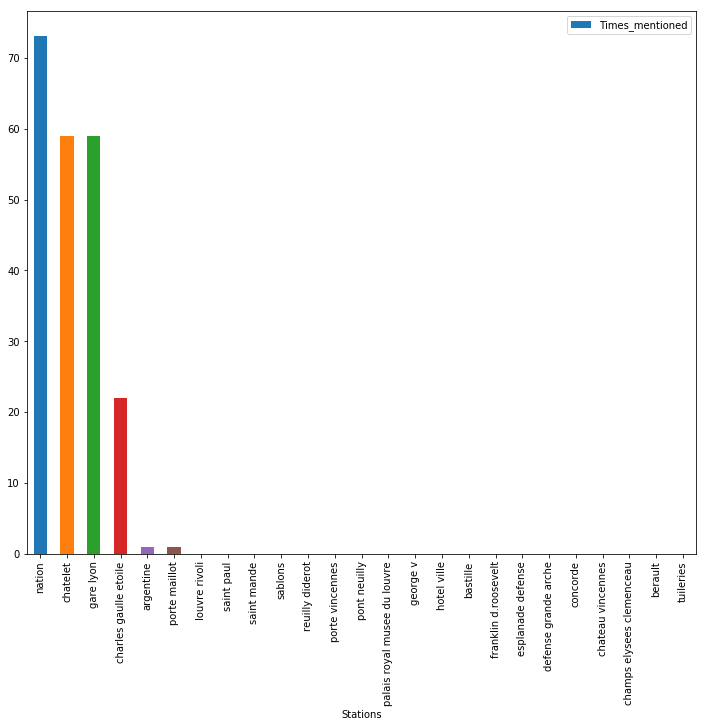

In [884]:
plot_traffic_problem_stations()

In [701]:
text = 'porte de l\'italie'
if 1 == 1:
    text = text.lower()
    text = re.sub(r"-", " ", text)
    text = re.sub(r"\sd\'", "de ", text)
    text = re.sub(r"\sl\'", "le ", text)
    text = re.sub(r"\sle\s", " ", text)
    text = re.sub(r"\sla\s", " ", text)
    text = re.sub(r"\sles\s", " ", text)
    text = re.sub(r"le\s", " ", text)
    text = re.sub(r"la\s", " ", text)
    text = re.sub(r"les\s", " ", text)

    text = re.sub(r"\sde\s", " ", text)
    text = re.sub(r"\sdes\s", " ", text)
    text = re.sub(r"\sà\s", " ", text)
    text = re.sub(r"\sau\s", " ", text)
    text = re.sub(r"\saux\s", " ", text)
    text = re.sub(r"\ssur\s", " ", text)
    text = re.sub(r"\\'", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
text

'portede italie'

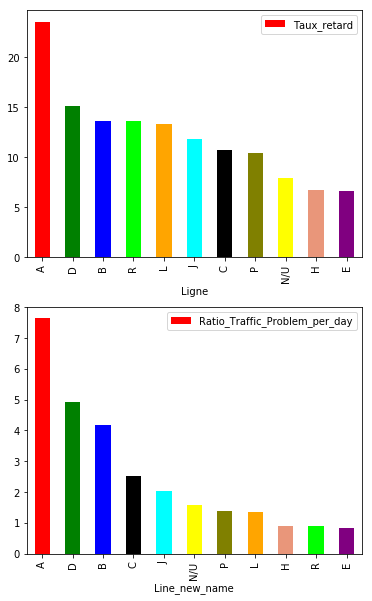

In [574]:
plot_sncf_twitter_comparison()

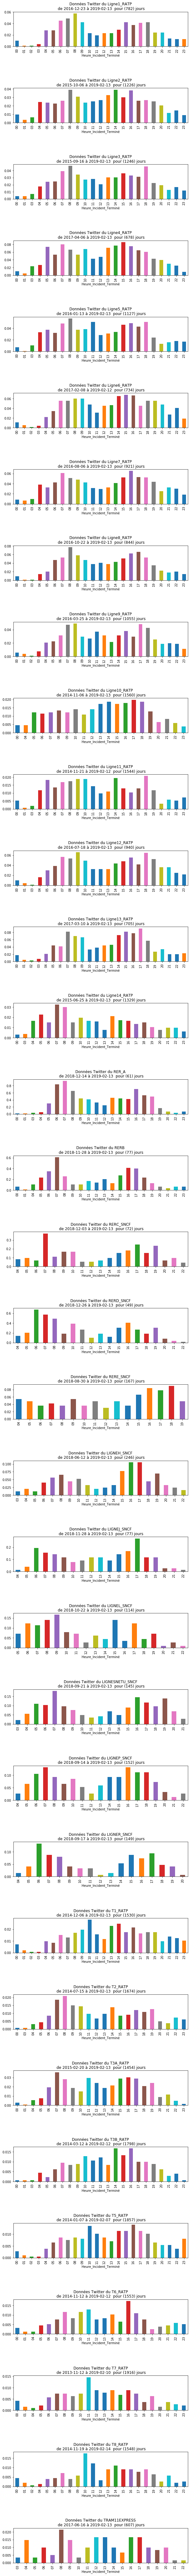

In [576]:
plot_incidents('by_hour')

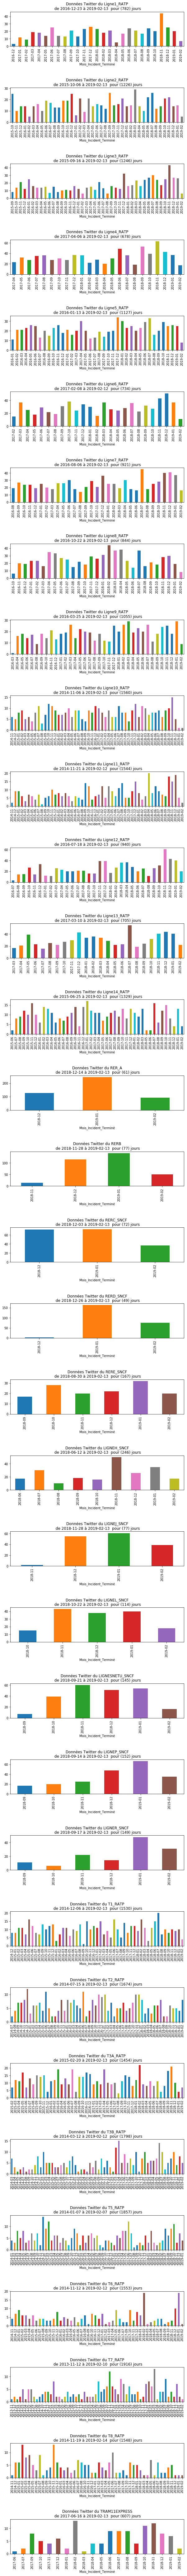

In [577]:
plot_incidents('by_year_month')

In [593]:
df_stations.columns

Index(['Geo Point', 'Geo Shape', 'id_ref_zdl', 'gares_id', 'nom_gare',
       'nomlong', 'nom_iv', 'num_mod', 'mode_', 'fer', 'train', 'rer', 'metro',
       'tramway', 'navette', 'val', 'terfer', 'tertrain', 'terrer', 'termetro',
       'tertram', 'ternavette', 'terval', 'idrefliga', 'idrefligc', 'ligne',
       'cod_ligf', 'ligne_code', 'indice_lig', 'reseau', 'res_com', 'cod_resf',
       'res_stif', 'exploitant', 'num_psr', 'idf', 'principal', 'x', 'y'],
      dtype='object')

In [670]:
df_stations[df_stations['res_com'] == 'M1'][['nom_gare', 'nom_iv']]

,nom_gare,nom_iv
108,Bérault,Bérault
117,Château de Vincennes,Château de Vincennes
122,Esplanade de la Défense,Esplanade de la Défense
138,Nation,Nation
144,Pont de Neuilly (Avenue de Madrid),Pont de Neuilly
158,Reuilly-Diderot,Reuilly-Diderot
230,Bastille,Bastille
240,Champs-Élysées-Clémenceau,Champs-Elysées-Clémenceau
248,George-V,George V
254,Gare de Lyon,Gare de Lyon


In [755]:
df_stations['nom_gare']

0                    Ella Fitzgerald
1               Porte de la Villette
2                         Rosa Parks
3                       Butte Pinson
4                  Petit Pierrefitte
5                        Roger Sémat
6              Marché de Saint-Denis
7             Villejuif-Louis Aragon
8                          Lamartine
9                   Domaine Chérioux
10                    Auguste Perret
11                    La Belle Epine
12                Parc André Malraux
13                   Hôpital Béclère
14                           Louvois
15                      Pablo Néruda
16                     VIROFLAY R.D.
17                   BOULAINVILLIERS
18                            BOURAY
19                    BOURG-LA-REINE
20              BOUSSY-SAINT-ANTOINE
21                           BIÈVRES
22                   CROUY-SUR-OURCQ
23                             ABLON
24                           ANDRÉSY
25                            ANTONY
26                    ARCUEIL-CACHAN
2

In [54]:

fi = open('Usager_RERB_hashtaged.jsonl', 'w')
with open('user_timeline_Usager_RERB.jsonl', 'r') as f:
    for line  in f.readlines():
        s = json.loads(line)
        condition_1 = ( ''.join(s['text'].split()[:2]) == 'RT@RERB:')
        condition_2 = (bool(re.search("#RERB", s['text'],re.IGNORECASE)))                         
        condition_3 = (bool(re.search("@RERB", s['text'],re.IGNORECASE))) 
        condition_4 = (bool(re.search("\sRERB\s", s['text'],re.IGNORECASE)))  
        condition_5 = (bool(re.search("\sRER\sB\s", s['text'],re.IGNORECASE)))  

        if (condition_1 or condition_2 or condition_3 or condition_4 or condition_5):
            fi.write(line)
fi.close()



In [55]:
fi = open('RERBnator_hashtaged.jsonl', 'w')
with open('user_timeline_RERBnator.jsonl', 'r') as f:
    for line  in f.readlines():
        s = json.loads(line)
        condition_1 = ( ''.join(s['text'].split()[:2]) == 'RT@RERB:')
        condition_2 = (bool(re.search("#RERB", s['text'],re.IGNORECASE)))                         
        condition_3 = (bool(re.search("@RERB", s['text'],re.IGNORECASE))) 
        condition_4 = (bool(re.search("\sRERB\s", s['text'],re.IGNORECASE)))  
        condition_5 = (bool(re.search("\sRER\sB\s", s['text'],re.IGNORECASE)))  

        if (condition_1 or condition_2 or condition_3 or condition_4 or condition_5):
            fi.write(line)
fi.close()

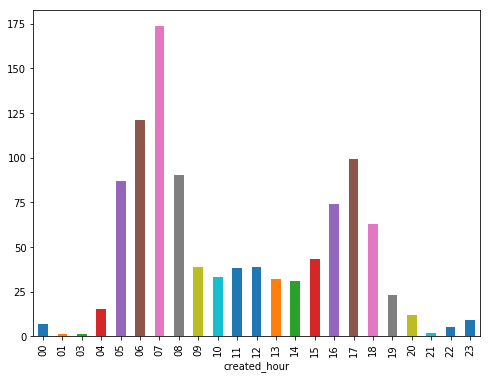

In [183]:
list_traffic_signe_problem = ['perturbation', 'retard', 'incident', 'panne', 'alarme', 'avarie' \
                              'anormalie', 'signalisation', 'signal', 'acte de malveillance' \
                              'Bagage oublié', 'Interruption', 'perturbé', 'obstacle' \
                             'interrompu', 'Reprise', 'ralentissement', 'Accident', 'victime' \
                              'défaut', 'malaise', 'retardé', 'stationne']

def detect_problem(x):
    for i in list_traffic_signe_problem:
        if bool(re.search(i,x, re.IGNORECASE)):
            value = True
            break
        else:
            value = False
    return value
df['traffic_problem'] = df['text'].apply(detect_problem)
df[df['traffic_problem'] == True].groupby(df['created_hour']).size().plot(kind='bar',  figsize=(8,6))
 